In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

# IBM Quantum Challenge 2021
## Exercise 5 - Variational Quantum Eigensolver
### VQE for LiH molecule 


The goal was to simulate LiH molecule using the STO-3G basis with the PySCF driver, and find the best ansatz, in terms of the number of CNOT gates, a lower number being better.

Some hints to reduce the number of qubits were
- freezing the core electrons that do not contribute significantly to chemistry and consider only the valence electrons. Inspect the different transformers in `qiskit_nature.transformers`  and find the one that performs the freeze core approximation.
- Using `ParityMapper` with `two_qubit_reduction=True` to eliminate 2 qubits.
- Reducucing the number of qubits by inspecting the symmetries of your Hamiltonian using `Z2Symmetries` in Qiskit.

I basically studied these hints from the Qiskit Nature API reference and implemented them in the solution. 

In addition, I considered the LiH molecule properties to decide orbitals to remove.LiH is Lithium and Hydrogen. The orbitals are 
- H: 1s 
- Li: 1s, 2s, px, py, pz
The Li 1s electrons do not form bonds i.e. are core electrons and thus could be removed by FreezeCore. 
Then expected H 1s electrons to interact with Li 2s electrons. Initially, I then thought I can remove p orbitals 3,4 and 5, but could not achieve ground state. It turns out that there is some mixing with Li pz orbital in the bonding so only px and py i.e. 3 and 4 can be removed. Orbital removal could be done with FreezeCore.

For the ansatz, TwoLocal in combination with SPSA or SLSQP optimizer looked promising from the previous part a) of the exercise so I tried those. The 'default' with 3 repetitions and full entanglement worked fine with score 18. Then experimented with reducing the repetions, which amazingly went to just 1 and score 6! 

Progress next came after checking ?TwoLocal. I realized there were other entanglements like linear, circular and even a map. Mapping with [(0,1), (1, 2), (2, 3), (3, 0)] worked fantastic bringing the score to 4! From this point the returns of experimenting were diminishing. I actually thought 4 was the limit. Then I realized that somehow the entanglement (3,0) was somehow more important. This made me try mixing in such 'reversed' entanglements until finally [(3, 2), (2, 1), (1, 0)] worked! This 'reverse' linear was fantastic (actually might suggest additions of such reversed maps to TwoLocal i.e. 'reversed linear', 'reversed circular'). I still haven't figured out the 'scientific' reason why entanglement in that direction worked.

The full code is below. Hope it is useful!

## Code

In [2]:
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 
from qiskit.algorithms import VQE
from IPython.display import display, clear_output
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit.opflow import X, Y, Z, I, PauliSumOp, Z2Symmetries


### Exact diagonalizer and callback 

In [3]:
def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

In [4]:
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

In [5]:
# Definitition of the problem
## Takes a FreezeCoreTransformer with choice to freeze_core and list of orbitals to remove
problem = ElectronicStructureProblem(driver, 
            q_molecule_transformers=[FreezeCoreTransformer(freeze_core=True, remove_orbitals=[3,4])])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]
mapper = ParityMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[-1])

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
#print(init_state)
#ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)

# TwoLocal Ansatz
# Single qubit rotations that are placed on all qubits with independent parameters
rotation_blocks = ['rz','rx']
# Entangling gates
entanglement_blocks = ['cx']
# How the qubits are entangled 
entangler_map1 = [(0,1), (1, 2), (2, 3), (3, 0)]
entangler_map2 = [(3, 2), (2, 1), (1, 0)]
entanglement = entangler_map2
#entanglement = 'linear'

# Repetitions of rotation_blocks + entanglement_blocks with independent parameters
repetitions = 1
# Skip the final rotation_blocks layer
skip_final_rotation_layer = False
ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                  entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
# Add the initial state
ansatz.compose(init_state, front=True, inplace=True)
#ansatz.draw()
backend = Aer.get_backend('statevector_simulator')

optimizer = SLSQP(maxiter=500)

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
#print(result_exact)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

'Evaluation: 700, Energy: -1.0862138177821778, Std: 0.0'

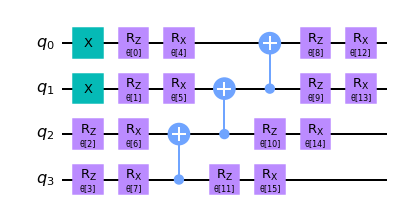

In [6]:
ansatz.draw()